<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/SupervisedML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=227a30df8f75cbedba566084ac6a94ffb8a767224f74c0e1201c35a31d5a787e
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('supervised_ml_classification').getOrCreate()

In [3]:
df = spark.read.csv('sample_data/bank_data.csv', inferSchema=True, header=True)
print((df.count(), len(df.columns)))

(41188, 21)


In [4]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- target_class: string (nullable = true)



In [5]:
df.groupBy('target_class').count().show()

+------------+-----+
|target_class|count|
+------------+-----+
|          no|36548|
|         yes| 4640|
+------------+-----+



## Deleting rows to reduce data size and no of columns

In [6]:
# Calculate the fraction to keep 'no' records such that 30,000 'no' records are dropped
total_no_records = 36548
records_to_keep = total_no_records - 30000
fraction_to_keep = records_to_keep / total_no_records

# Define the fractions dictionary for sampling
fractions = {'no': fraction_to_keep, 'yes': 1.0}

# Sample the DataFrame based on the fractions
sampled_df = df.sampleBy("target_class", fractions, seed=42)

# Now select the columns you want to keep
columns_to_keep = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'target_class']
new_df = sampled_df.select(columns_to_keep)

# Show the result to verify
new_df.show(5)

# Optionally, check the count of 'no' and 'yes' in the new DataFrame
new_df.groupBy('target_class').count().show()

+---+-----------+-------+-----------+-------+-------+----+------------+
|age|        job|marital|  education|default|housing|loan|target_class|
+---+-----------+-------+-----------+-------+-------+----+------------+
| 41|blue-collar|married|    unknown|unknown|     no|  no|          no|
| 35|blue-collar|married|   basic.6y|     no|    yes|  no|          no|
| 50|blue-collar|married|   basic.9y|     no|    yes| yes|          no|
| 59| technician|married|    unknown|     no|    yes|  no|          no|
| 34|   services|married|high.school|     no|     no|  no|          no|
+---+-----------+-------+-----------+-------+-------+----+------------+
only showing top 5 rows

+------------+-----+
|target_class|count|
+------------+-----+
|          no| 6573|
|         yes| 4640|
+------------+-----+



## Feature Engineering for Model

In [7]:
from pyspark.sql import functions as F
from pyspark.sql import *
new_df = new_df.withColumn("label", F.when(new_df.target_class=='no', F.lit(0)).otherwise(F.lit(1)))
new_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 4640|
|    0| 6573|
+-----+-----+



In [8]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

def cat_to_num(df):
    stages = [] # to keep the stages of the transformations

    for col in df.columns:
        stringIndexer = StringIndexer(inputCol=col, outputCol=col+"_index")
        encoder = OneHotEncoder(inputCols=[col+"_index"], outputCols=[col+"_vec"])

        stages += [stringIndexer, encoder]

    df_assembler = VectorAssembler(inputCols=['age','marital_vec','education_vec','default_vec','housing_vec','loan_vec'], outputCol="features")
    stages += [df_assembler]

    # Applying all the transformations
    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(df)
    df = model.transform(df)

    return df.select(['features', 'label'])

df_new = cat_to_num(new_df)


In [9]:
df_new.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,10,12,14...|    0|
|(17,[0,1,9,11,13,...|    0|
|(17,[0,1,6,11,13,...|    0|
|(17,[0,1,10,11,13...|    0|
|(17,[0,1,5,11,14,...|    0|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,1,5,11,14,...|    0|
|(17,[0,1,7,12,13,...|    0|
|(17,[0,1,9,12,14,...|    0|
|(17,[0,1,4,11,14,...|    0|
|(17,[0,2,6,11,13,...|    0|
|(17,[0,1,10,11,13...|    0|
|(17,[0,1,4,12,13,...|    0|
|(17,[0,3,8,12,13,...|    1|
|(17,[0,1,6,12,14,...|    0|
|(17,[0,1,4,12,13,...|    1|
|(17,[0,1,6,11,14,...|    1|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,3,4,11,14,...|    0|
+--------------------+-----+
only showing top 20 rows



## Split the Data into Train and Test Datasets

In [10]:
train, test = df_new.randomSplit([0.75,0.25])
print(f"Size of train Dataset : {train.count()}")
print(f"Size of test Dataset : {test.count()}")

Size of train Dataset : 8352
Size of test Dataset : 2861


## Build and Train the Logistic Regression model

In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(train)
print(lr_model.coefficients)

[0.01641233948038232,-0.4644018971664534,-0.08925667015176925,-0.5560692511224847,-0.2133016426858599,-0.5030033017982235,-0.7106452125661693,-0.4101850344903137,-0.41304435151332786,-0.6801408043759767,-0.09224831958944113,11.880843129566573,10.977024198744944,-0.010516604033838401,-0.009020085496566447,-0.00901640697606993,-0.0276488107199148]


## Evaluate Performance on Training Data

In [12]:
lr_summary = lr_model.summary
print(f"{lr_summary.accuracy}")
print(f"{lr_summary.areaUnderROC}")
print(f"{lr_summary.weightedRecall}")
print(f"{lr_summary.weightedPrecision}")

0.6076388888888888
0.6217879550209418
0.607638888888889
0.5911047044719471


In [13]:
lr_summary.precisionByThreshold.show()

+------------------+------------------+
|         threshold|         precision|
+------------------+------------------+
|0.6927964207595616|               1.0|
|0.6772780360250148|               0.5|
|0.6727363146889228|0.6666666666666666|
| 0.660995701027655|             0.625|
|0.6555800554514206|               0.5|
|0.6510390739547156|0.5833333333333334|
|0.6457909733219936|               0.6|
|0.6414901629794747| 0.631578947368421|
| 0.638592524319546|0.6190476190476191|
|0.6371680286655732|0.6086956521739131|
|0.6347961356718733|               0.6|
|0.6300894868870168|0.5925925925925926|
|0.6286509656348738|0.6060606060606061|
|0.6278755396153862|0.6285714285714286|
|0.6251622532794873|0.6216216216216216|
|0.6233075894424016|0.6153846153846154|
|0.6209562762572028|0.6190476190476191|
| 0.619277894326395|0.6363636363636364|
|0.6185698149162924|0.6521739130434783|
| 0.615215684536039|0.6666666666666666|
+------------------+------------------+
only showing top 20 rows



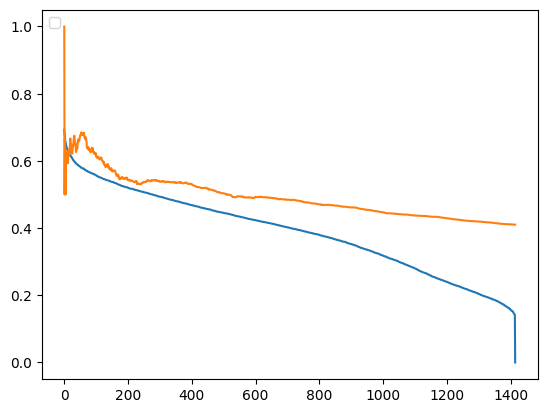

In [14]:
import matplotlib.pyplot as plt

# Assuming lr_summary is a BinaryClassificationMetrics object

# Get the precision by threshold DataFrame
precision_by_threshold = lr_summary.precisionByThreshold

# Collect the DataFrame to the driver
precision_by_threshold_list = precision_by_threshold.collect()

# Extract threshold and precision values
thresholds = [row['threshold'] for row in precision_by_threshold_list]
precisions = [row['precision'] for row in precision_by_threshold_list]

# Now use matplotlib to plot the precision against threshold
plt.plot(precision_by_threshold_list)
plt.legend(loc='upper left')
plt.show()


## **Different Graphs**
* From the ROC Curve, a curve close to the top-left corner indicates a better performance.
* From the Precision-Recall Curve, a higher area under the curve (AUC) indicates that the classifier is returning more true positives and fewer false negatives.
* The Threshold vs. Metrics Plot will show you how the balance between precision and recall changes as you adjust the threshold. The optimal point often maximizes the F-Measure, which balances precision and recall.
* The Confusion Matrix is a direct way to see the actual versus predicted counts of the classes.
* For a Calibration Curve, if the plot significantly deviates from the diagonal, it indicates that the predicted probabilities are not representative of the actual outcomes.

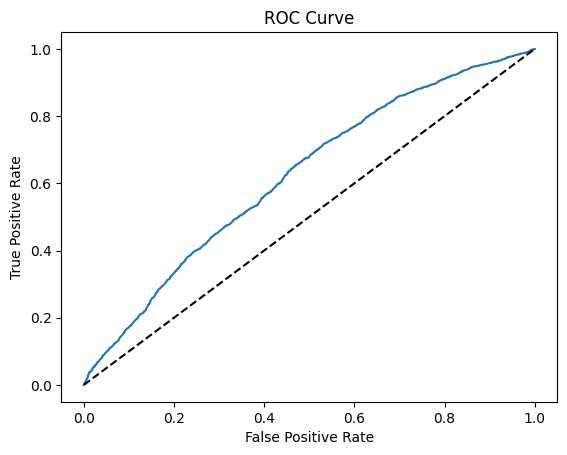

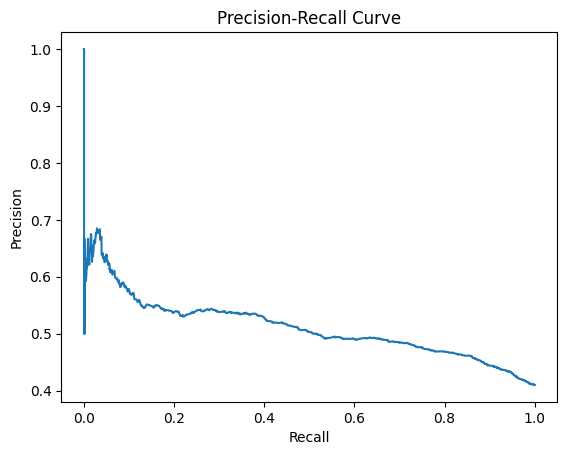

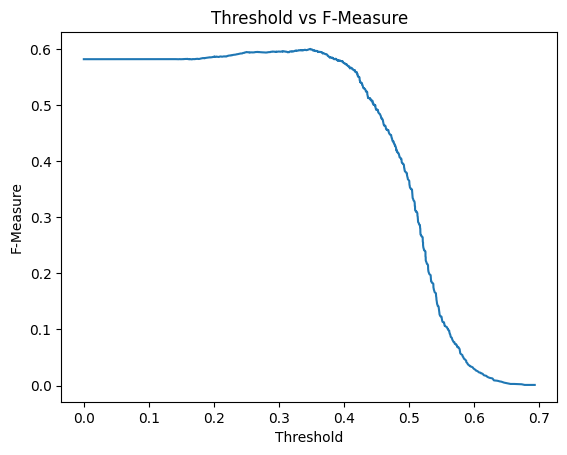

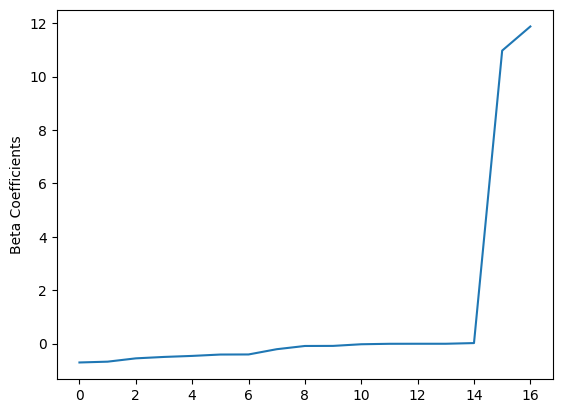

In [15]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Assuming predictions is a DataFrame with the logistic regression model's predictions
# It needs to have a column with the label and a column with the prediction

# ROC Curve
roc = lr_summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision-Recall Curve
pr = lr_summary.pr.toPandas()
plt.figure()
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Threshold vs. Metrics Plot
f_measure = lr_summary.fMeasureByThreshold.toPandas()
plt.figure()
plt.plot(f_measure['threshold'], f_measure['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-Measure')
plt.title('Threshold vs F-Measure')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
plt.show()


In [16]:
lr_summary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|5.837711617046118E-4|
|4.060089321965083E-4|5.837711617046118E-4|
|4.060089321965083E-4|0.001167542323409...|
|6.090133982947625E-4|0.001459427904261...|
|0.001015022330491...|0.001459427904261...|
|0.001015022330491...|0.002043199065966...|
|0.001218026796589525|0.002626970227670753|
|0.001421031262687...|0.003502626970227...|
|0.001624035728786...|0.003794512551079...|
|0.001827040194884...|0.004086398131932283|
|0.002030044660982...|0.004378283712784...|
|0.002233049127080796|0.004670169293636894|
|0.002639058059277304|0.005837711617046118|
|0.002639058059277304| 0.00642148277875073|
|0.002842062525375...|0.006713368359603036|
|0.003045066991473...|0.007005253940455...|
|0.003248071457572...|0.007589025102159953|
|0.003248071457572...|0.008172796263864565|
|0.003248071457572...|0.00875656

In [17]:
lr_summary.recallByThreshold.show()

+------------------+--------------------+
|         threshold|              recall|
+------------------+--------------------+
|0.6927964207595616|5.837711617046118E-4|
|0.6772780360250148|5.837711617046118E-4|
|0.6727363146889228|0.001167542323409...|
| 0.660995701027655|0.001459427904261...|
|0.6555800554514206|0.001459427904261...|
|0.6510390739547156|0.002043199065966...|
|0.6457909733219936|0.002626970227670753|
|0.6414901629794747|0.003502626970227...|
| 0.638592524319546|0.003794512551079...|
|0.6371680286655732|0.004086398131932283|
|0.6347961356718733|0.004378283712784...|
|0.6300894868870168|0.004670169293636894|
|0.6286509656348738|0.005837711617046118|
|0.6278755396153862| 0.00642148277875073|
|0.6251622532794873|0.006713368359603036|
|0.6233075894424016|0.007005253940455...|
|0.6209562762572028|0.007589025102159953|
| 0.619277894326395|0.008172796263864565|
|0.6185698149162924|0.008756567425569177|
| 0.615215684536039|0.009340338587273789|
+------------------+--------------

In [18]:
lr_summary.pr.show()

+--------------------+------------------+
|              recall|         precision|
+--------------------+------------------+
|                 0.0|               1.0|
|5.837711617046118E-4|               1.0|
|5.837711617046118E-4|               0.5|
|0.001167542323409...|0.6666666666666666|
|0.001459427904261...|             0.625|
|0.001459427904261...|               0.5|
|0.002043199065966...|0.5833333333333334|
|0.002626970227670753|               0.6|
|0.003502626970227...| 0.631578947368421|
|0.003794512551079...|0.6190476190476191|
|0.004086398131932283|0.6086956521739131|
|0.004378283712784...|               0.6|
|0.004670169293636894|0.5925925925925926|
|0.005837711617046118|0.6060606060606061|
| 0.00642148277875073|0.6285714285714286|
|0.006713368359603036|0.6216216216216216|
|0.007005253940455...|0.6153846153846154|
|0.007589025102159953|0.6190476190476191|
|0.008172796263864565|0.6363636363636364|
|0.008756567425569177|0.6521739130434783|
+--------------------+------------

## Evaluate Performance on test data

In [19]:
model_predictions = lr_model.transform(test)
model_predictions.columns

['features', 'label', 'rawPrediction', 'probability', 'prediction']

In [20]:
model_predictions.select(['label', 'probability', 'prediction']).show(10, False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.5916488015469463,0.4083511984530537] |0.0       |
|0    |[0.5555385250982281,0.4444614749017719] |0.0       |
|0    |[0.5392752263800553,0.4607247736199447] |0.0       |
|1    |[0.5392752263800553,0.4607247736199447] |0.0       |
|0    |[0.5351949196876015,0.46480508031239853]|0.0       |
|0    |[0.5351949196876015,0.46480508031239853]|0.0       |
|1    |[0.5229278747621774,0.4770721252378226] |0.0       |
|0    |[0.5106331076026841,0.4893668923973159] |0.0       |
|1    |[0.596359404133549,0.40364059586645096] |0.0       |
|1    |[0.596359404133549,0.40364059586645096] |0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [22]:
# RMSE value of the model on test data
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_auroc = lr_evaluator.evaluate(model_predictions)
print(f'The auc value of Logistic Regression Model is {lr_auroc}')


# RMSE value of the model on test data
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
lr_aupr = lr_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {lr_aupr}')

The auc value of Logistic Regression Model is 0.6409441958770832
The aupr value of Logistic Regression Model is 0.556493922479282


In [23]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()


In [24]:
#Recall
float(true_pos)/(actual_pos)

0.28665568369028005

In [25]:
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()
#Precision
float(true_pos)/(pred_pos)

0.5752066115702479

## **Decision Tree Classifier**

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_model = dt.fit(train)

In [27]:
model_predictions = dt_model.transform(test)

In [28]:
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.6336633663366337,0.36633663366336633]|0.0       |
|0    |[0.5319577252138903,0.4680422747861097] |0.0       |
|0    |[0.5319577252138903,0.4680422747861097] |0.0       |
|1    |[0.5319577252138903,0.4680422747861097] |0.0       |
|0    |[0.5319577252138903,0.4680422747861097] |0.0       |
|0    |[0.5319577252138903,0.4680422747861097] |0.0       |
|1    |[0.5319577252138903,0.4680422747861097] |0.0       |
|0    |[0.5319577252138903,0.4680422747861097] |0.0       |
|1    |[0.6336633663366337,0.36633663366336633]|0.0       |
|1    |[0.6336633663366337,0.36633663366336633]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [29]:
# RMSE value of the model on test data
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
dt_auroc = dt_evaluator.evaluate(model_predictions)
print(f'The auc value of Decision Tree Classifier Model is {dt_auroc}')


# RMSE value of the model on test data
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
dt_aupr = dt_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {dt_aupr}')

The auc value of Decision Tree Classifier Model is 0.47005238419611717
The aupr value of Logistic Regression Model is 0.4029127172862316


In [30]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [31]:
#Recall
float(true_pos)/(actual_pos)


0.2215815485996705

In [32]:
#Precision on test Data
float(true_pos)/(pred_pos)

0.7289972899728997

## **Support Vector Machines**

## Build and train SVM model

In [33]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=50,maxDepth=30)
rf_model = rf.fit(train)

In [34]:
model_predictions = rf_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.40862643020162,0.5913735697983801]   |1.0       |
|0    |[0.5297607425481897,0.47023925745181033]|0.0       |
|0    |[0.4854619720112568,0.5145380279887433] |1.0       |
|1    |[0.4854619720112568,0.5145380279887433] |1.0       |
|0    |[0.4854619720112568,0.5145380279887433] |1.0       |
|0    |[0.4854619720112568,0.5145380279887433] |1.0       |
|1    |[0.44062863867792346,0.5593713613220767]|1.0       |
|0    |[0.4255068095374622,0.5744931904625378] |1.0       |
|1    |[0.5688934678328629,0.43110653216713707]|0.0       |
|1    |[0.5688934678328629,0.43110653216713707]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



## Evaluate performance on test data

In [35]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(model_predictions)
print(f'The auc value of RandomForestClassifier Model is {rf_auroc}')

rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(model_predictions)
print(f'The aupr value of RandomForestClassifier Model is {rf_aupr}')


The auc value of RandomForestClassifier Model is 0.6638073918031788
The aupr value of RandomForestClassifier Model is 0.5977529592367787


In [36]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()


In [37]:
#Recall
float(true_pos)/(actual_pos)

0.2940691927512356

In [38]:
#Precision on test Data
float(true_pos)/(pred_pos)


0.6102564102564103

# **Naive bayes Classifier**

## Build and train NaiveBayes model

In [39]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes()
nb_model = nb.fit(train)
model_predictions = nb_model.transform(test)
model_predictions.columns

['features', 'label', 'rawPrediction', 'probability', 'prediction']

In [40]:
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.515292115084086,0.4847078849159141]  |0.0       |
|0    |[0.510283732491732,0.48971626750826797] |0.0       |
|0    |[0.5080570619462131,0.49194293805378697]|0.0       |
|1    |[0.5080570619462131,0.49194293805378697]|0.0       |
|0    |[0.5075003409054291,0.49249965909457083]|0.0       |
|0    |[0.5075003409054291,0.49249965909457083]|0.0       |
|1    |[0.5058300716925084,0.4941699283074917] |0.0       |
|0    |[0.5041596723339177,0.4958403276660824] |0.0       |
|1    |[0.5221322317694879,0.47786776823051225]|0.0       |
|1    |[0.5221322317694879,0.47786776823051225]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [41]:
nb_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
nb_auroc = nb_evaluator.evaluate(model_predictions)
print(f'The auc value of NB Classifier  is {nb_auroc}')

nb_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
nb_aupr =nb_evaluator.evaluate(model_predictions)
print(f'The aupr value of NB Classifier Model is {nb_aupr}')

The auc value of NB Classifier  is 0.5440724436322236
The aupr value of NB Classifier Model is 0.4639701881258607


In [42]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [43]:
float(true_pos)/(actual_pos)

0.21828665568369027

In [44]:
float(true_pos)/(pred_pos)

0.5614406779661016

## **Gradient Boosted Tree Classifier**

In [45]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier()
gbt_model = gbt.fit(train)
model_predictions = gbt_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.4870668771054246,0.5129331228945754] |1.0       |
|0    |[0.5771865199736715,0.42281348002632846]|0.0       |
|0    |[0.5693664349308929,0.4306335650691071] |0.0       |
|1    |[0.5693664349308929,0.4306335650691071] |0.0       |
|0    |[0.5521785942314487,0.44782140576855134]|0.0       |
|0    |[0.5521785942314487,0.44782140576855134]|0.0       |
|1    |[0.5763593752385344,0.4236406247614656] |0.0       |
|0    |[0.5403460331273872,0.45965396687261284]|0.0       |
|1    |[0.50788401501044,0.49211598498956]     |0.0       |
|1    |[0.50788401501044,0.49211598498956]     |0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [46]:
gbt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
gbt_auroc = gbt_evaluator.evaluate(model_predictions)
print(f'The auc value of GradientBoostedTreesClassifier  is {gbt_auroc}')

gbt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
gbt_aupr = gbt_evaluator.evaluate(model_predictions)
print(f'The aupr value of GradientBoostedTreesClassifier Model is {gbt_aupr}')


The auc value of GradientBoostedTreesClassifier  is 0.669204354380037
The aupr value of GradientBoostedTreesClassifier Model is 0.6060662459792


In [47]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()


In [48]:
float(true_pos)/(actual_pos)


0.2800658978583196

In [49]:

float(true_pos)/(pred_pos)

0.6296296296296297

# **Random Forest Classifier**

In [50]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=50, maxDepth=30)
rf_model = rf.fit(train)
model_predictions = rf_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.40862643020162,0.5913735697983801]   |1.0       |
|0    |[0.5297607425481897,0.47023925745181033]|0.0       |
|0    |[0.4854619720112568,0.5145380279887433] |1.0       |
|1    |[0.4854619720112568,0.5145380279887433] |1.0       |
|0    |[0.4854619720112568,0.5145380279887433] |1.0       |
|0    |[0.4854619720112568,0.5145380279887433] |1.0       |
|1    |[0.44062863867792346,0.5593713613220767]|1.0       |
|0    |[0.4255068095374622,0.5744931904625378] |1.0       |
|1    |[0.5688934678328629,0.43110653216713707]|0.0       |
|1    |[0.5688934678328629,0.43110653216713707]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



## Evaluate Performance on Test Data

In [52]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(model_predictions)
print(f"THe auc value of RandomForestClassifier Model is {rf_auroc}")

THe auc value of RandomForestClassifier Model is 0.6638073918031788


In [54]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(model_predictions)
print(f"THe aupr value of RandomForestClassifier Model is {rf_aupr}")

THe aupr value of RandomForestClassifier Model is 0.5977529592367787


In [55]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [56]:
float(true_pos)/(actual_pos)

0.2940691927512356

In [57]:
float(true_pos)/(pred_pos)

0.6102564102564103

## **Hyperparameter Tuning and Cross-Validation**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestClassifier()
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5,10,20,25,30])
             .addGrid(rf.maxBins, [20,30,40,50 ])
             .addGrid(rf.numTrees, [5, 20,50,100])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=rf_evaluator, numFolds=10)
cv_model = cv.fit(train)

In [ ]:
best_rf_model = cv_model.bestModel